<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL07_3_XAI_Kermitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KERMIT and KERMITviz 🐸

KERMIT paper: https://virtual.2020.emnlp.org/paper_main.1210.html

In [220]:
#Clone repository and install libraries
!rm -r KERMIT
!git clone https://github.com/ART-Group-it/KERMIT

Cloning into 'KERMIT'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 653 (delta 163), reused 62 (delta 41), pack-reused 419
Receiving objects: 100% (653/653), 14.66 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (335/335), done.


In [221]:
!git clone https://github.com/ariana2011/shared_weights

fatal: destination path 'shared_weights' already exists and is not an empty directory.


In [222]:
!pip install transformers

In [223]:
!pip install stanza

In [224]:
!pip install ./KERMIT/kerMIT

Processing ./KERMIT/kerMIT
  Preparing metadata (setup.py) ... done
  Created wheel for kerMIT: filename=kerMIT-2.0-py3-none-any.whl size=203665 sha256=9ee6bb64e9e429bad48b6bbdd06be6ea08004f392a4925a8bf0843d05d73bf45
  Stored in directory: /tmp/pip-ephem-wheel-cache-tkps8o5h/wheels/b5/83/6e/92611dbf1d7b0ec1799f68368b47833243d7bfc31560b5d4cb
Successfully built kerMIT
  Attempting uninstall: kerMIT
    Found existing installation: kerMIT 2.0
    Uninstalling kerMIT-2.0:
      Successfully uninstalled kerMIT-2.0


In [225]:
! pip install datasets

## Create dataset

In [226]:
#download and install parser (stanfordcorenlp is the library that was build before stanza, mostly written in java)
#!pip install stanfordcorenlp
#!wget http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
#!unzip stanford-corenlp-full-2018-10-05.zip


import stanza
nlp = stanza.Pipeline('en', processors='tokenize,pos,constituency')

ERRORS = []

#takes sentences and parse freetext in parenthetical tree
def parse(text):
    text = (text.encode('ascii', 'ignore')).decode("utf-8")

    try:
        try:
            doc = nlp(text)
        except Exception:
            ERRORS.append(text)
            return "(S)"

        senteces = doc.sentences
        #check if there are more than one sentence
        if len(senteces) <= 1:
            root = str(senteces[0].constituency)
        else:
            s1 = str(senteces[0].constituency)
            root = "(S" + s1
            for sentence in senteces[1:]:
                s2 = str(sentence.constituency)
                root = root + s2
            root = root + ")"
        return root
    except Exception:
        ERRORS.append(text)
        return "(S)"

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| mwt          | combined            |
| pos          | combined_charlm     |
| constituency | ptb3-revised_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: constituency
INFO:stanza:Done loading processors!


In [227]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("glue", "sst2", split={'train':'train', 'test':'validation'})
dataset = dataset.shuffle(seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
})

In [228]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
})

In [229]:
max_len = {'train':4000, 'test': 400}
for split in ['train', 'test']:
    dataset[split] = dataset[split].select([i for i in range(max_len[split])])
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 400
    })
})

In [230]:
import numpy as np

np.sum(np.array(dataset['train']['label']) == 0), np.sum(np.array(dataset['test']['label']) == 0)

(1806, 189)

### Parse

In [231]:
#from kerMIT.tree_encode import parse as parse_tree # working with stanfordcorenlp

def parse_example(example):
    example['ptext'] = str(parse(example['sentence'])) #parse_tree
    return example


for split in ['train', 'test']:
    dataset[split] = dataset[split].map(parse_example)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### Distributed trees

In [254]:
TREE_DIM = 512
LAMBDA = 0.5


from kerMIT.dtk import DT
from kerMIT.operation import fast_shuffled_convolution
from kerMIT import tree

# encoder: takes a tree as input and compute the corresponding distributed tree
encoder = DT(dimension=TREE_DIM, LAMBDA=LAMBDA, operation=fast_shuffled_convolution)


def compute_distributed_tree(example):
    t = tree.Tree(string=example['ptext'])
    dt = encoder.dt(t)
    example['t'] = str(t)
    example['dt'] = dt
    return example

for split in ['train', 'test']:
    dataset[split] = dataset[split].map(compute_distributed_tree, num_proc=100)

Map (num_proc=100):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=100):   0%|          | 0/400 [00:00<?, ? examples/s]

In [255]:
dataset['train']['dt'][0]

[-0.07816229648876002,
 -0.12890933334120983,
 0.2620093034141668,
 0.01991379638345948,
 -0.07938321376226146,
 -0.09590064283741555,
 0.3057119261030242,
 -0.10928208209936344,
 -0.10972006449996644,
 0.014288799846595382,
 -0.05853813740329025,
 -0.17327732506657614,
 -0.2973010818545604,
 0.03300080294961305,
 0.09740428053402841,
 0.12257178673075415,
 0.1795463632722691,
 -0.1818378618083274,
 0.09959165299923207,
 0.3658965469556189,
 -0.12397606496648025,
 -0.08892906468056819,
 -0.01721817995772821,
 -0.2660532126212299,
 -0.032545194133543544,
 -0.17080465252185242,
 -0.19080934970103625,
 -0.27546662786536463,
 0.015066721016897964,
 0.12688911228519084,
 0.04595199586518084,
 0.06543143887474986,
 0.11983543093176302,
 -0.23105888476457273,
 0.017716466703421547,
 -0.04497684451947864,
 -0.03191553474751091,
 0.20387907888631882,
 0.005661650706871725,
 -0.22031602872299336,
 -0.22270660376319423,
 -0.025994204561363192,
 -0.048455982348220544,
 0.30011446707844625,
 0.2569

In [256]:
print(len(ERRORS), dataset['train'][0])
display(dataset)

0 {'sentence': 'klein , charming in comedies like american pie and dead-on in election , ', 'label': 1, 'idx': 32326, 'ptext': '(ROOT (FRAG (ADJP (NNP klein)) (, ,) (ADJP (JJ charming) (PP (IN in) (NP (NP (NNS comedies)) (PP (IN like) (NP (JJ american) (NN pie)))))) (CC and) (ADJP (JJ dead) (HYPH -) (IN on)) (PP (IN in) (NP (NN election))) (, ,)))', 't': '(ROOT (FRAG (ADJP (NNP klein)) (, ,) (ADJP (JJ charming) (PP (IN in) (NP (NP (NNS comedies)) (PP (IN like) (NP (JJ american) (NN pie)))))) (CC and) (ADJP (JJ dead) (HYPH -) (IN on)) (PP (IN in) (NP (NN election))) (, ,)))', 'dt': [-0.07816229648876002, -0.12890933334120983, 0.2620093034141668, 0.01991379638345948, -0.07938321376226146, -0.09590064283741555, 0.3057119261030242, -0.10928208209936344, -0.10972006449996644, 0.014288799846595382, -0.05853813740329025, -0.17327732506657614, -0.2973010818545604, 0.03300080294961305, 0.09740428053402841, 0.12257178673075415, 0.1795463632722691, -0.1818378618083274, 0.09959165299923207, 0.3658

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'ptext', 't', 'dt', 'target'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'ptext', 't', 'dt', 'target'],
        num_rows: 400
    })
})

In [257]:
def label_to_target(example):
    example['target'] = [0.0, 0.0]
    example['target'][example['label']] = 1.0
    return example

for split in ['train', 'test']:
    dataset[split] = dataset[split].map(label_to_target, num_proc=100)

Map (num_proc=100):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=100):   0%|          | 0/400 [00:00<?, ? examples/s]

In [258]:
train_dataset = dataset['train'].select(list(range(1800))).with_format('torch')
val_dataset = dataset['train'].select(list(range(1800,2000))).with_format('torch')
test_dataset  = dataset['test'].with_format('torch')

In [259]:
train_dataset['target'].shape, train_dataset['dt'].shape

(torch.Size([1800, 2]), torch.Size([1800, 512]))

In [260]:
from torch.utils.data import DataLoader, SequentialSampler
import torch

def create_dataloader(dataset, **kwargs):
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
    else:
        batch_size = 16

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    dataloader = DataLoader(
        dataset,  # The training samples.
        sampler = SequentialSampler(dataset), # Select batches IN SEQUENCE NB: usually there is a Random Loader for train
        batch_size = batch_size, # batch size in split
        generator= torch.Generator().manual_seed(42)
    )
    return dataloader

train_dataloader = create_dataloader(train_dataset)
val_dataloader = create_dataloader(val_dataset)
test_dataloader = create_dataloader(test_dataset)

## Model

In [261]:
import os
import sys
import transformers
import torch
from torch import nn
from torch import optim

#set manual seed for replicability
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(23)

# If there's a GPU available...
DEVICE_NUM = 0
def load_device(DEVICE_NUM):
    if torch.cuda.is_available():

        # Tell PyTorch to use the GPU.
        device = torch.device("cuda")

        print('There are %d GPU(s) available.' % torch.cuda.device_count())

        print('We will use the GPU:', torch.cuda.get_device_name(DEVICE_NUM))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    return device

device = load_device(DEVICE_NUM)
device

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


device(type='cuda')

In [262]:
OUTPUT_DIM = 2
HIDDEN_SIZE = 128

In [263]:
from torch import nn
torch.manual_seed(42)

class FeedForward(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        out = self.linear_1(x)
        out = self.relu(out)
        out = self.linear_2(out)
        return out

    def get_activations(self, x):
        with torch.no_grad():
            A = [x] + [None] * 2 #(num linear layers)

            out = self.linear_1(x)
            out = self.relu(out)
            A[1] = out

            out = self.linear_2(out)
            A[2] = out
            return A

model = FeedForward(TREE_DIM, OUTPUT_DIM, HIDDEN_SIZE)
model.to(device)

FeedForward(
  (linear_1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=128, out_features=2, bias=True)
)

## Train

In [264]:
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import pearsonr, spearmanr

METRICS = {
    'sentiment': lambda y_true, y_pred: {
        "f1_score": f1_score(y_true, y_pred),
        "accuracy_score":accuracy_score(y_true, y_pred)
    }
}

In [265]:
# Train model
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
def get_optim(model, **kwargs):
    if 'lr' in kwargs:
        lr = kwargs['lr']
    else:
        lr = 5e-5

    if 'eps' in kwargs:
        eps = kwargs['eps']
    else:
        eps = 1e-8

    optimizer = AdamW(model.parameters(),
                      lr=5e-5,  # args.learning_rate - default is 5e-5
                      eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                      )
    return optimizer


from transformers import get_linear_schedule_with_warmup

def schedule(optimizer, epochs, train_dataloader):
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)
    return scheduler

from torch.nn import BCEWithLogitsLoss

def get_criterion():
    return nn.BCEWithLogitsLoss()

In [266]:
def compute_score(metric, logits, labels, return_preds=False):
    # Get predictions from the maximum value
    pred_flat = np.argmax(logits.cpu().numpy(), axis=1).flatten()
    labels_flat = np.argmax(labels.cpu().numpy(), axis=1).flatten()

    if not return_preds:
        return metric(labels_flat, pred_flat)
    else:
        return metric(labels_flat, pred_flat), pred_flat, labels_flat


import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
def training_loop(model, epochs, optimizer, scheduler, criterion, train_dataloader, validation_dataloader):
    model.train()
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        total_train_score = {}

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains pytorch tensors:
            b_dt = batch['dt'].to(device)
            b_labels = batch['target'].float().to(device)

            # print(b_dt.shape, b_labels.shape)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward`
            # function and pass down the arguments.
            logits = model(b_dt)
            #print("logits", logits)

            # calculate loss (sigmoid on logits, then compare with targets)
            loss = criterion(logits, b_labels)


            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')

            score = compute_score(METRICS['sentiment'], logits, b_labels)
            for m, v in score.items():
                if m not in total_train_score:
                    total_train_score[m] = 0
                total_train_score[m] += v



        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)


        # Report the final accuracy for this train run.
        for m in total_train_score:
            total_train_score[m] = total_train_score[m] / len(train_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_train_score[m]))


        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_loss = 0
        nb_eval_steps = 0
        total_score = {}

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_dt = batch['dt'].to(device)
            b_labels = batch['target'].float().to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward`
            # function and pass down the arguments.
            with torch.no_grad():
                logits = model(b_dt)

            # calculate loss (sigmoid on logits, then compare with targets)
            loss = criterion(logits, b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            score = compute_score(METRICS['sentiment'], logits, label_ids)
            for m, v in score.items():
                if m not in total_score:
                    total_score[m] = 0
                total_score[m] += v


        # Report the final accuracy for this validation run.
        for m in total_score:
            total_score[m] = total_score[m] / len(validation_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_score[m]))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        stat = {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
        for m in total_train_score:
            stat["Training "+m] = total_train_score[m]

        for m in total_score:
            stat["Valid. "+m] = total_score[m]

        # Record all statistics from this epoch.
        training_stats.append(stat)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')

    return df_stats

In [289]:
EPOCHS = 15

optimizer = get_optim(model)
scheduler = schedule(optimizer, EPOCHS, train_dataloader)
criterion = get_criterion()

train_stats = training_loop(model, EPOCHS, optimizer, scheduler, criterion,
                            train_dataloader, val_dataloader)
display(train_stats)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:00.
  Batch    80  of    113.    Elapsed: 0:00:01.
  f1_score: 0.79
  accuracy_score: 0.75

  Average training loss: 0.54
  Training epcoh took: 0:00:01

Running Validation...
  f1_score: 0.68
  accuracy_score: 0.60
  Validation Loss: 0.66
  Validation took: 0:00:00

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:00.
  Batch    80  of    113.    Elapsed: 0:00:01.
  f1_score: 0.79
  accuracy_score: 0.75

  Average training loss: 0.54
  Training epcoh took: 0:00:02

Running Validation...
  f1_score: 0.68
  accuracy_score: 0.60
  Validation Loss: 0.66
  Validation took: 0:00:00

======== Epoch 3 / 15 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:01.
  Batch    80  of    113.    Elapsed: 0:00:01.
  f1_score: 0.79
  accuracy_score: 0.75

  Average training loss: 0.53
  Training epcoh took: 0:00:01

Running Validation...
  f1_score: 0.68
  accuracy_s

,Training Loss,Valid. Loss,Training Time,Validation Time,Training f1_score,Training accuracy_score,Valid. f1_score,Valid. accuracy_score
epoch,,,,,,,,
1,0.540348,0.660490,0:00:01,0:00:00,0.789342,0.745022,0.682282,0.600962
2,0.536505,0.661164,0:00:02,0:00:00,0.791106,0.748341,0.682282,0.600962
3,0.533219,0.661764,0:00:01,0:00:00,0.793798,0.752212,0.682282,0.600962
4,0.530178,0.662310,0:00:01,0:00:00,0.795300,0.754425,0.682282,0.600962
5,0.527393,0.662822,0:00:01,0:00:00,0.797074,0.757190,0.682282,0.600962
6,0.524852,0.663307,0:00:01,0:00:00,0.800769,0.761615,0.677620,0.596154
7,0.522565,0.663733,0:00:01,0:00:00,0.801795,0.763274,0.677620,0.596154
8,0.520521,0.664128,0:00:01,0:00:00,0.801302,0.762721,0.677620,0.596154
9,0.518723,0.664471,0:00:01,0:00:00,0.802271,0.763827,0.677620,0.596154


## Test

In [290]:
import pandas as pd

def test(model, prediction_dataloader):
    # Put model in evaluation mode
    model.eval()

    model.to(device)

    # Tracking variables
    predictions, true_labels = [], []

    # Predict
    for batch in prediction_dataloader:
        # Unpack the inputs from our dataloader
        b_dt, b_labels = batch['dt'], batch['target']
        b_dt = b_dt.to(device)
        b_labels = b_labels.to(device)

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            logits = model(b_dt)

        m, preds, labels = compute_score(METRICS['sentiment'], logits, b_labels, return_preds=True)
        predictions.extend(preds)
        true_labels.extend(labels)


    score = pd.DataFrame([])
    score['pred'] = predictions
    score['true'] = true_labels

    return score

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       189
           1       0.59      0.67      0.62       211

    accuracy                           0.57       400
   macro avg       0.57      0.57      0.57       400
weighted avg       0.57      0.57      0.57       400



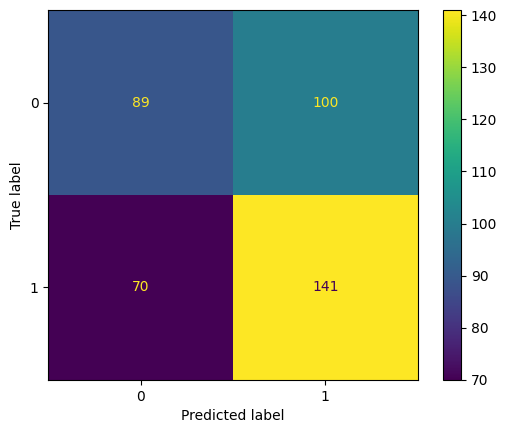

In [291]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

score = test(model, test_dataloader)

y_true = score['true']
y_pred = score['pred']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

print(classification_report(y_pred=y_pred, y_true=y_true))

## Explainations

Original notebook from Leonardo Ranaldi:
https://github.com/LeonardRanaldi/Practical-NLP-2022

In [292]:
from kerMIT.tree_encode import parse as parse_tree
from kerMIT.samples import utils

from kerMIT import tree
from kerMIT.dtk import DT
from tqdm import tqdm
import re, torch, pickle, copy
from torchtext import data as datx
from torch import nn, optim
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [293]:
import os
import sys
import transformers
import torch
from torch import nn
from torch import optim

#set manual seed for replicability
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)
torch.cuda.is_available()

True

In [302]:
sentence = dataset['test']['sentence'][0]
target = dataset['test']['label'][0]
pt = dataset['test']['t'][0]
dt =  dataset['test']['dt'][0]

In [303]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def getWeightAnBiasByName(layer_name):
    weight, bias = _,_
    for name, param in model.named_parameters():
        if name == layer_name+'.weight' and param.requires_grad:
            weight = param.data
        elif name == layer_name+'.bias' and param.requires_grad:
            bias = param.data
    return weight, bias

def lrp_linear_torch(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = torch.where(hout.cpu() >= 0 , torch.Tensor([1.]), torch.Tensor([-1.])).view(1,-1) # shape (1, M)

    numer    = (w * hin.view(-1,1)).cpu() + ( bias_factor * (b.view(1,-1)*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

    denom    = hout.view(1,-1) + (eps*sign_out*1.)   # shape (1, M)

    message  = (numer/denom) * Rout.view(1,-1)       # shape (D, M)

    Rin      = message.sum(axis=1)              # shape (D,)

    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note:
    # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections
    # -> can be used for sanity check

    return Rin

def prepare_single_pass(activation, start_layer, end_layer, isFirstCompute=True):
    hout = activation[start_layer].reshape(-1)
    if end_layer != None:
        hin = activation[end_layer].reshape(-1).cpu()
    else:
        hin = None

    w, b = getWeightAnBiasByName(start_layer)
    w = w.reshape(w.shape[1],w.shape[0])

    bias_nb_units = b.shape[0]
    eps = 0.001
    bias_factor = 1.0

    if isFirstCompute:
        mask = torch.zeros( hout.shape[0] )
        mask[ torch.argmax(hout) ] = hout[ torch.argmax(hout) ]
        Rout = torch.Tensor(mask).cpu()
    else:
        Rout = None
    return hin, w.cpu(), b.cpu(), hout.cpu(), Rout, bias_nb_units, eps, bias_factor

def compute_LRP_FFNN(activation, layer_names, on_demand_embedding_matrix, single_test):
    isFirstCompute = True
    for i in range(len(layer_names)-1):
        print(layer_names[i], layer_names[i+1])
        hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor = prepare_single_pass(activation, layer_names[i], layer_names[i+1], isFirstCompute)
        if not isFirstCompute:
            Rout = Rin
        Rin = lrp_linear_torch(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        isFirstCompute = False
    # compute the last layer
    _, w, b, hout, _, bias_nb_units, eps, bias_factor = prepare_single_pass(activation, layer_names[-1], None, False)
    Rout = Rin
    hin = single_test.reshape(-1).cpu()

    Rin = lrp_linear_torch(hin, torch.matmul(on_demand_embedding_matrix,w), b, hout, Rout, bias_nb_units, eps, bias_factor, debug=False)
    return Rin


In [304]:
# resister forward hook for activation
model.linear_1.register_forward_hook(get_activation('linear_1'))
model.linear_2.register_forward_hook(get_activation('linear_2'))
layer_names = ['linear_2','linear_1']

In [305]:
from kerMIT.explain.modelToExplain import lrp_DT,relevance_to_string
from kerMIT.explain.activationSubtreeLRP import ActivationSubtreeLRP

In [306]:
# prediction
dt = torch.tensor(dt).unsqueeze(dim=0).to(device)
print(dt.shape)
output = model(dt)
output

torch.Size([1, 512])


tensor([[-1.0298,  1.0263]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [311]:
torch.argmax(output, axis=1), target

(tensor([1], device='cuda:0'), 1)

Given the tree t, this block computes its dtfs, the input vector of the subtrees, and the LRP activations.

In [ ]:
import numpy as np

tree_pt = tree.Tree(string=pt)
act_lrp = ActivationSubtreeLRP(encoder)

_, tree_index_dict, on_demand_embedding_matrix, tree_index_dict_inverse, activation_vector = act_lrp.on_demand_embedding_matrix(tree_pt)

on_demand_embedding_matrix = torch.Tensor(on_demand_embedding_matrix)
activation_vector = torch.Tensor(activation_vector)
relevance = compute_LRP_FFNN(activation, layer_names, on_demand_embedding_matrix, activation_vector)

act_tree_lrp = act_lrp.saveActivation(tree_pt, relevance, tree_index_dict)
active_subtrees = sorted(act_tree_lrp['act_sub_trees'], key=lambda x:x[1], reverse=True)
for t in active_subtrees:
  print(t)


In [ ]:
from kerMIT.explain import kerMITviz

#visualization of previously extracted activations through heat parse tree
heat_parse_tree = kerMITviz.assign_contribution_nodes(act_tree_lrp)

In [ ]:
heat_parse_tree

In [ ]:
import IPython
import fileinput

### Display heat parse tree

In [ ]:
brotherDistance = "5"
levelLength = "50"
#brotherDistance = input('Enter brother Distance in px (recommended 5): ')
#levelLength = input('Enter level Lenght in px (recommended 50: ')

In [ ]:
string = str(heat_parse_tree)

name = "var string"
name1 = "var brotherDistance"
name2 = "var levelLength"

!cp '/content/KERMIT/Visualizer/notebook/index.html' '/content/KERMIT/Visualizer/notebook/index_New.html'
!cp '/content/KERMIT/Visualizer/notebook/index2.html' '/content/KERMIT/Visualizer/notebook/index2_New.html'


with open('/content/KERMIT/Visualizer/notebook/index_New.html','r') as names_file:
    content = names_file.read()
    new = content.replace(name, '='.join([name, '"' + string + '"']))
    new = new.replace(name1, '='.join([name1, brotherDistance]))
    new = new.replace(name2, '='.join([name2, levelLength]))

with open('/content/KERMIT/Visualizer/notebook/index_New.html','w') as new_names_file:
    new_names_file.write(new)


with open('/content/KERMIT/Visualizer/notebook/index2_New.html','r') as names_file:
    content = names_file.read()
    new = content.replace(name, '='.join([name, '"' + string + '"']))
    new = new.replace(name1, '='.join([name1, brotherDistance]))
    new = new.replace(name2, '='.join([name2, levelLength]))

with open('/content/KERMIT/Visualizer/notebook/index2_New.html','w') as new_names_file:
    new_names_file.write(new)

In [ ]:
IPython.display.HTML(filename='/content/KERMIT/Visualizer/notebook/index2_New.html')